<a href="https://colab.research.google.com/github/WyvernCore/ARI1101---Data-Science-individual/blob/master/Advanced_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning #//used to install py lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-krowlk4q
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-krowlk4q
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!apt-get install -y xvfb #display enviroment videos 
!pip install \ gym==0.21 \ gym[box2d] \ pyvirtualdisplay #pyvirtualdisplay -> render enviroment in notebook

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400,900)).start() #create the display

In [ ]:
import copy
import gym 
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn #create the Neural network
from torch.utils.data import DataLoader #load training data
from torch.utils.data.dataset import IterableDataset #Define where we get our data
from torch.optim import AdamW #optimizer

from pytorch_lightning import LightningModule, Trainer 
from pytorch_lightning.callbacks import EarlyStopping

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #run code on gpu if avialable 
num_gpus = torch.cuda.device_count()

In [ ]:
def display_video(episode = 0): #convert video to html to render enviroment here
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4',"r+b").read()
  video_url = f'data:video/mp4;base64, {b64encode(video_file).decode()}'
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

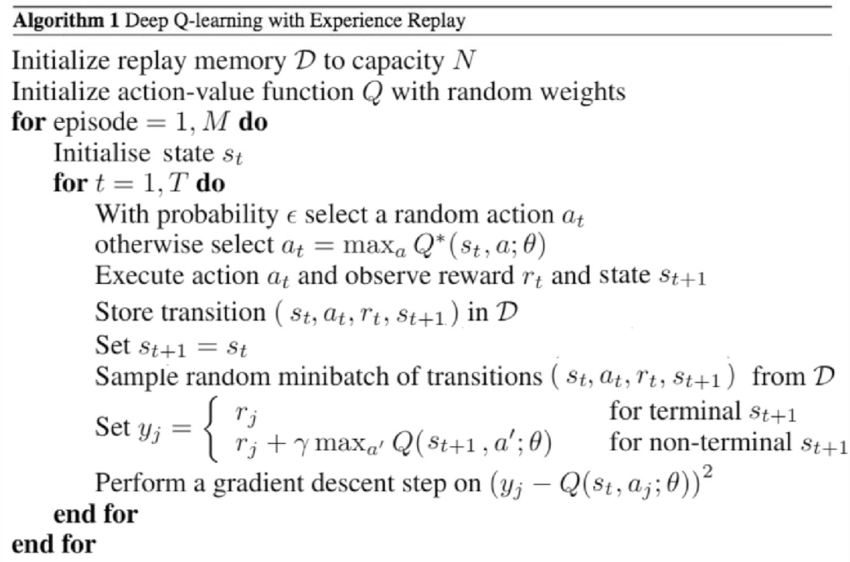

Deep Q-Network

In [ ]:
class DQN(nn.Module):

  def __init__(self, hidden_size,  obs_size, n_actions): #pass the amount of hidden layers, the observation size (vector of features) [x, y, z], number of actions [q1, q2, q3]
    super().__init__()
    self.net == nn.Sequential( #Using a Sequential Neural Network
        nn.Linear(obs_size, hidden_size), #Linear activation function  | Input Layer
        nn.ReLU(), #ReLU activation function
        nn.Linear(hidden_size, hidden_size), #Linear activation function | Hidden Layer 
        nn.ReLU(), #ReLU activation function
        nn.Linear(hidden_size, n_actions) #Linear activation function | Output Layer 
    )
  
  def forward(self, x): #What happens when an observation is passed
    return self.net(x.float()) #tensor foating point values


The Policy

In [ ]:
#fn: state -> action || [p1, p2, p3]

def e_greedy(state, env, net, epsilon=0.0): #The E-Greedy Policy 
  if np.random.random() < epsilon:
    action = env.action_space.sample() #take a random action
  else: # 1 - e
    state = torch.tensor([state]).to(device) #Pass a batch of observations | device -> CPU or GPU
    q_values = net(state) #Produce q_values from NN
    _, action = torch.max(q_values, dim=1) #Take the max q_value action | torch.max passes two values, the actual value and the index (we only care about the index)
    action = int(action.item()) #make sure its a integer
  return action

Replay Buffer

In [ ]:
class ReplayBuffer: #Store enviroment observations (kinda like a database) | Stored as [State, Action, Reward, Next State] 
  def __init__(self, capacity): #defining the capacity of the replay buffer
    self.buffer = deque(maxlen=capacity) #Using a queue data structure

  def __len__(self):  #return the length of the buffer
    return len(self.buffer)
  
  def append(self, experience): #save experience in the database
    self.buffer.append(experience)
  
  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size) #get a sample of explisit buffer size

In [ ]:
class RLDataset(IterableDataset): #class to allow pytorch to select a sample from buffer one at a time (the batch)
  def __init__(self, buffer, sample_size=200): #go through each element one at a time
    self.buffer = buffer
    self.sample_size = sample_size
  
  def __iter__(self): #take a sample from buffer and return elements one at a time
    for exp in self.buffer.sample(self.sample_size):
      yield exp

Environment

In [ ]:
def create_environment(name): #Using gym to easily create an enviroment and pass the name of it
  env = gym.make(name)
  env = TimeLimit(env, max_episode_steps=400)
  env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x%50 == 0) #record every fifty episodes
  env = RecordEpisodeStatistics(env) #Keep history of rewards from the env
  return env

In [ ]:
env = create_environment('LunarLander-v2') #Create the enviroment for lunar lander

for episode in range(10):
  done = False
  env.reset()
  while not done:
    action = env.action_space.sample() #take random actions
    _, _, done, _ = env.step(action)


In [ ]:
display_video(episode=0)

In [ ]:
class DeepQLearning(LightningModule): #Implementing the Algorithm

  # Initialize
  def __init__(self, env_name, policy=e_greedy, capacity=100000, 
               batch_size=256, lr=0.1, hidden_size=128, gamma=0.99, loss_fn=F.smooth_l1_loss,
               optim=AdamW, eps_start=1.0, eps_end=0.15, eps_last_episode=100, samples_per_epoch=10000
               , sync_rate=10):
    
    super.__init__()
    self.env = create_environment(env_name) #pass the enviroment name to create the environment

    obs_size = self.env.observation_space.shape[0] #get observation size
    n_actions  = self.action_space.n #get action size

    self.q_net = DQN(hidden_size, obs_size, n_actions) #Instansiate the Deep Q-Network

    self.target_q_net = copy.deepcopy(self.q_net) #Create a copy for target policy

    self.policy = policy #Get the policy
    self.buffer = ReplayBuffer(capacity=capacity) #create the reply buffer

    self.save_hyperparameters() #keep passed hyperparameters saved

    while len(self.buffer) < self.hparams.samples_per_epoch: #keep filling buffer
      print(f"{len(self.buffer)} samples in expience buffer. Filling....")
      self.play_episode(epsilon=self.hparams.eps_start)

    @torch.no_grad() #treat actions as constants 
    def play_episode(self, policy=None, epsilon=0.):
      state = self.env.reset()
      done = False

      while not done:
        if policy: #if a policy is present get action selected by the policy
          action = policy(state, self.env, self.q_net, epsilon=epsilon)
        else: #if not pick a random action
          action = self.env.action_space.sample()
        next_state, reward, done, info = self.env.step(action) #take an action in the enviroment
        exp = (state, action, reward, done, next_state) #store the exp to be stored in the exp replay buffer
        self.buffer.append(exp) #save in the buffer 
        state = next_state #set next to curr
    
  # Foward Pass
  
    def forward(self, x): #take a state input -> produce q value
      return self.q_net(x)

  # Configure Optimizers

    def configure_optimizers(self): 
      q_net_optimizers = self.hparams.optim(self.q_net_optimizers(), lr=self.hparams.lr)
      return [q_net_optimizers] #might be more than one NN thus rap in list

  # Create dataloader

    def train_dataloader(self):
      dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
      dataloader = DataLoader(
          dataset = dataset,
          batch_size=self.hparams.batch_size
      )
      return dataloader

  # Training step

    def training_step(self, batch, batch_idx):
      states, actions, rewards, dones, next_states = batch #retrieve data from batch
      actions = actions.unsqueeze(1) #create an extra dim to solve size diff
      rewards = rewards.unsqueeze(1)
      dones = dones.unsqueeze(1)

      state_action_values = self.q_net(states).gather(1, actions) #get Q(s,a) value from neural network

      next_action_values, _ = self.target_q_net(next_states).max(dim=1, keepdim=True) #keepdim keeps orginal dim, get target q(s', a') values
      next_action_values[dones] = 0.0 #set done values to zero
      
      expected_state_action_values = rewards + self.hparams.gamma * next_action_values # gamma is the discount factor

      loss = self.hparams.loss_fn(state_action_values, expected_state_action_values) #compute loss values with the mean sq diff (varient)
      self.log('episode/Q-Error', loss)

      return loss

  # Training epoch end

  def training_epoch_end(self, training_step_outputs):
    epsilon = max(
        self.hparams.eps_end,
        self.hparams.eps_start - self.current_epoch /  self.hparams.eps_last_episode
    )

    self.play_episode(policy=self.policy, epsilon=epsilon)
    self.log('episode/Return', self.env.return_queue[-1])

    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

TensorBoard

In [ ]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

Train the policy

In [ ]:
algo = DeepQLearning('LunarLander-v2')

trainer = Trainer(
    gpus=num_gpus,
    max_epochs=10_000,
    callbacks=[EarlyStopping(monitor='episode/Returns', mode='max', patience=500)]
)

trainer.fit(algo)